# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb

---

# Setup

In [1]:
%run "/code/source/config/notebook_settings.py"

In [2]:
from itertools import islice
import pandas as pd
from helpsk.logging import Timer
from helpsk.pandas import non_numeric_summary, numeric_summary
from source.library.text_analysis import count_tokens, tf_idf, get_context_from_keyword, \
    count_keywords, count_keywords_by, impurity
from source.library.notebook_helpers import plot_hdi, percentiles
from source.library.datasets import DATA

pd.set_option('display.max_colwidth', None)

In [3]:
with Timer("Loading Data"):
    reddit = DATA.reddit.load()
    reddit_corpus = DATA.reddit_corpus.load()

2023-03-21 17:59:02 - INFO     | Timer Started: Loading Data
2023-03-21 17:59:02 - INFO     | Loading data `reddit` from `/code/artifacts/data/raw/reddit.pkl`
2023-03-21 17:59:02 - INFO     | Loading data `reddit_corpus` from `/code/artifacts/data/processed/reddit_corpus.pkl`
2023-03-21 17:59:16 - INFO     | Timer Finished: (14.15 seconds)


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

## Dataset Summary

In [4]:
reddit.head(1)

,id,subreddit,title,post
0,8f73s7,Harley,No Club Colors,"Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs &amp; Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. <lb><lb>Cheers. Ride safe, boys!"


### Numeric Summary

In [5]:
numeric_summary(reddit)

### Non-Numeric

In [6]:
non_numeric_summary(reddit)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
id,"20,000",0,0.0%,8f73s7,"20,000",100.0%
subreddit,"20,000",0,0.0%,Harley,20,0.1%
title,"20,000",0,0.0%,Need some advice,"19,957",99.8%
post,"20,000",0,0.0%,Funny story. I went to college[...],"20,000",100.0%


In [24]:
reddit_corpus.to_dataframe(columns='all', first_n=2)

,text_original,text_clean,lemmas_important,bi_grams
0,"Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs &amp; Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. <lb><lb>Cheers. Ride safe, boys!","Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. Cheers. Ride safe, boys!","[funny, story, college, las, vegas, know, motorcycle, whatsoever, college, buddy, strip, dance, club, end, bar, hogs, heifers, worth, note, female, work, outdrink, sign, door, read, club, color, lose, tie, blazer, head, assume, bright, color, like, red, yellow, green, etc, allow, bring, xtra, t, shirt, pair, jean, year, look, naive, hilarious, able, walk, bar, crawl, booze, cheer, ride, safe, boy]","[funny-story, las-vegas, motorcycle-whatsoever, college-buddy, dance-club, hogs-heifers, worth-note, female-work, club-color, assume-bright, bright-color, color-like, like-red, red-yellow, yellow-green, green-etc, xtra-t, t-shirt, ride-safe, safe-boy]"
1,"I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won 2/3). But I was wondering if it was just because of the bigass supercharger in the Roush. <lb><lb><lb>Also I can't find the same specs on any two websites, what are some trustworthy sources for this kind of thing?","I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won _NUMBER_ / _NUMBER_ ). But I was wondering if it was just because of the bigass supercharger in the Roush. Also I can't find the same specs on any two websites, what are some trustworthy sources for this kind of thing?","[try, determine, fast, dealership, video, racing(roush, win, wonder, bigass, supercharger, roush, find, spec, website, trustworthy, source, kind, thing]","[dealership-video, racing(roush-win, bigass-supercharger, trustworthy-source]"


: 

---

### Examples

In [7]:
[x[0:300] for x in reddit['post'].iloc[0:20]]

["Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs &amp; Heifers. It's worth noting the females working there can outdrink",
 "I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won 2/3). But I was wondering if it was just because of the bigass supercharger in the Roush. <lb><lb><lb>Also I can't find the same specs on any two websites, what are some trustworthy sources for",
 "Hello! <lb><lb>Trying to find some information on replacing a 2001 Golf Wagon starter (gas).... mine's gone out and going to the dealership is quite out of the range right now. Nor is it in the biggest of rushes. <lb><lb>I live in Japan, and I'm wondering if anyone had any international shipping web",
 "https://www.cars.com/articles/how-often-should-i-change-engine-coolant-142068085366

In [8]:
['|'.join(x) for x in islice(reddit_corpus.lemmas(), 20)]

['funny|story|college|las|vegas|know|motorcycle|whatsoever|college|buddy|strip|dance|club|end|bar|hogs|heifers|worth|note|female|work|outdrink|sign|door|read|club|color|lose|tie|blazer|head|assume|bright|color|like|red|yellow|green|etc|allow|bring|xtra|t|shirt|pair|jean|year|look|naive|hilarious|able|walk|bar|crawl|booze|cheer|ride|safe|boy',
 'try|determine|fast|dealership|video|racing(roush|win|wonder|bigass|supercharger|roush|find|spec|website|trustworthy|source|kind|thing',
 'hello|try|find|information|replace|golf|wagon|starter|gas|dealership|range|right|big|rush|live|japan|wonder|international|shipping|website|recommend|direction|replace|manual|oh|specific|mention|japanese|tia',
 '_url_|awd|73|k|mile|touch|engine|radiator|coolant|find|change|book|long|life|100k|toyota|coolant|flushed|change|year|wait|100k',
 'hi|new|subreddit|consider|buy|gen1|volt|find|straight|answer|kind|mpg|battery|completely|dead|mile|trip|kind|highway|mpg|gen1|volt|battery|deplete',
 'lately|car|magnet|ding

In [9]:
['|'.join(x) for x in islice(reddit_corpus.n_grams(2), 20)]

['funny-story|las-vegas|motorcycle-whatsoever|college-buddy|dance-club|hogs-heifers|worth-note|female-work|club-color|assume-bright|bright-color|color-like|like-red|red-yellow|yellow-green|green-etc|xtra-t|t-shirt|ride-safe|safe-boy',
 'dealership-video|racing(roush-win|bigass-supercharger|trustworthy-source',
 'golf-wagon|wagon-starter|starter-gas|range-right|international-shipping|shipping-website',
 '73-k|k-mile|engine-radiator|radiator-coolant|long-life|life-100k|100k-toyota|toyota-coolant',
 'hi-new|consider-buy|gen1-volt|straight-answer|completely-dead|mile-trip|highway-mpg|gen1-volt',
 'reserve-spot|day-water|water-run|run-down|drive-usually|usually-mean|mean-water|water-run|run-down',
 'honda-dealership|oil-change|100k-mile|timing-belt|quote-price|timing-belt|belt-include|include-water|water-pump|pump-tensioner|coolant-service|google-suggest|local-mechanic|house-tomorrow|honda-dealership|reasonable-distance|price-quote|recommend-stick|timing-belt|local-shop|local-shop|good-revi

In [10]:
['|'.join(x) for x in islice(reddit_corpus.noun_phrases(), 20)]

['funny-story|college-buddy|dance-club|worth-note|female-work|assume-bright|bright-color|red-yellow|yellow-green|safe-boy',
 'dealership-video|racing(roush-win|bigass-supercharger|trustworthy-source',
 'starter-gas|international-shipping|shipping-website',
 'k-mile|engine-radiator|radiator-coolant|long-life',
 'consider-buy|straight-answer|mile-trip|highway-mpg|gen1-volt',
 'reserve-spot|day-water|water-run|mean-water|water-run',
 'oil-change|timing-belt|quote-price|timing-belt|belt-include|include-water|water-pump|pump-tensioner|coolant-service|google-suggest|local-mechanic|house-tomorrow|reasonable-distance|price-quote|recommend-stick|timing-belt|local-shop|local-shop|good-review|great-work|big-replacement|car-repair',
 'second-gear|starter-drive|drive-gear|gear-bendix|outer-primary|primary-cover|close-mechanic|mechanic-friend|look-perfect|couple-othe|othe-wrench|gear-rub',
 'bike-trip|meter-spot|right-saddlebag|spare-rag|water-able',
 'state-budget|budget-pass|include-provision|tax-

## Explore Non-Text Columns

#### Impurity

In [11]:
df = reddit_corpus.to_dataframe(columns=['impurity_original', 'impurity_clean', 'text_original', 'text_clean', 'lemmas_important'])
df.head(2)

,impurity_original,impurity_clean,text_original,text_clean,lemmas_important
0,0.01,0.00,"Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs &amp; Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. <lb><lb>Cheers. Ride safe, boys!","Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. Cheers. Ride safe, boys!","[funny, story, college, las, vegas, know, motorcycle, whatsoever, college, buddy, strip, dance, club, end, bar, hogs, heifers, worth, note, female, work, outdrink, sign, door, read, club, color, lose, tie, blazer, head, assume, bright, color, like, red, yellow, green, etc, allow, bring, xtra, t, shirt, pair, jean, year, look, naive, hilarious, able, walk, bar, crawl, booze, cheer, ride, safe, boy]"
1,0.02,0.00,"I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won 2/3). But I was wondering if it was just because of the bigass supercharger in the Roush. <lb><lb><lb>Also I can't find the same specs on any two websites, what are some trustworthy sources for this kind of thing?","I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won _NUMBER_ / _NUMBER_ ). But I was wondering if it was just because of the bigass supercharger in the Roush. Also I can't find the same specs on any two websites, what are some trustworthy sources for this kind of thing?","[try, determine, fast, dealership, video, racing(roush, win, wonder, bigass, supercharger, roush, find, spec, website, trustworthy, source, kind, thing]"


In [12]:
percentiles(list(reddit_corpus.impurities()))

,percentile,value
0,0.00,0.00
1,0.01,0.00
2,0.05,0.00
3,0.50,0.00
4,0.95,0.01
5,0.99,0.01
6,1.00,0.06


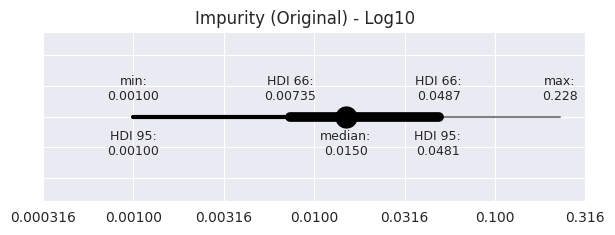

In [14]:
import numpy as np
plot_hdi(
    np.log10(df['impurity_original'].values + 0.001),
    transformation=lambda x: 10**x,
    title="Impurity (Original) - Log10"
)

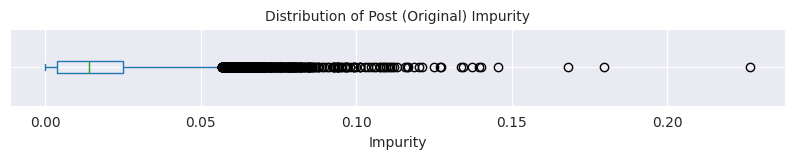

In [15]:
ax = df['impurity_original'].plot(kind='box', vert=False, figsize=(10, 1))
ax.set_title("Distribution of Post (Original) Impurity")
ax.set_xlabel("Impurity")
ax.set_yticklabels([])
ax;

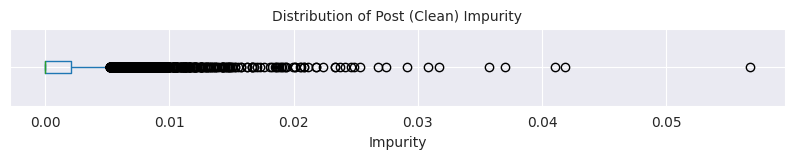

In [16]:
ax = df['impurity_clean'].plot(kind='box', vert=False, figsize=(10, 1))
ax.set_title("Distribution of Post (Clean) Impurity")
ax.set_xlabel("Impurity")
ax.set_yticklabels([])
ax;

In [17]:
df.sort_values('impurity_clean', ascending=False).head(2)

impurity_original  impurity_clean  \
17359               0.13            0.06   
8313                0.06            0.04   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [19]:
reddit['subreddit'].value_counts(ascending=False)

Harley                1000
Mustang               1000
saab                  1000
MPSelectMiniOwners    1000
mazda3                1000
Hyundai               1000
BMW                   1000
Trucks                1000
Porsche               1000
subaru                1000
Wrangler              1000
mercedes_benz         1000
Audi                  1000
teslamotors           1000
Honda                 1000
Volvo                 1000
volt                  1000
Lexus                 1000
Volkswagen            1000
4Runner               1000
Name: subreddit, dtype: int64

Explore idiosyncrasies of various columns, e.g. same speaker represented multiple ways.

---

## Explore Text Column|

### Top Words Used

In [22]:
df.head(2)

,impurity_original,impurity_clean,text_original,text_clean,lemmas_important
0,0.01,0.00,"Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs &amp; Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. <lb><lb>Cheers. Ride safe, boys!","Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. Cheers. Ride safe, boys!","[funny, story, college, las, vegas, know, motorcycle, whatsoever, college, buddy, strip, dance, club, end, bar, hogs, heifers, worth, note, female, work, outdrink, sign, door, read, club, color, lose, tie, blazer, head, assume, bright, color, like, red, yellow, green, etc, allow, bring, xtra, t, shirt, pair, jean, year, look, naive, hilarious, able, walk, bar, crawl, booze, cheer, ride, safe, boy]"
1,0.02,0.00,"I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won 2/3). But I was wondering if it was just because of the bigass supercharger in the Roush. <lb><lb><lb>Also I can't find the same specs on any two websites, what are some trustworthy sources for this kind of thing?","I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won _NUMBER_ / _NUMBER_ ). But I was wondering if it was just because of the bigass supercharger in the Roush. Also I can't find the same specs on any two websites, what are some trustworthy sources for this kind of thing?","[try, determine, fast, dealership, video, racing(roush, win, wonder, bigass, supercharger, roush, find, spec, website, trustworthy, source, kind, thing]"


In [23]:
remove_tokens = {'_number_', 'car'}
count_tokens(df['lemmas_important'], remove_tokens=remove_tokens).head(10)

,frequency
token,
look,11271
like,9466
drive,7574
know,7328
new,7238
want,6570
buy,6104
thank,6005
think,5851


---

### Distribution of Text Length

In [ ]:
ax = df['post_length'].plot(kind='box', vert=False, figsize=(10, 1))
ax.set_title("Distribution of Post Length")
ax.set_xlabel("# of Characters")
ax.set_yticklabels([])
ax;

In [ ]:
ax = df['post_length'].plot(kind='hist', bins=60, figsize=(10, 2));
ax.set_title("Distribution of Post Length")
ax.set_xlabel("# of Characters")
ax;

In [ ]:
import seaborn as sns
sns.displot(df['post_length'], bins=60, kde=True, height=3, aspect=3);

In [ ]:
where = df['subreddit'].isin([
    'Lexus', 
    'mercedes_benz',
    'Audi',
    'Volvo',
    'BMW',
])
g = sns.catplot(data=df[where], x="subreddit", y="post_length", kind='box')
g.fig.set_size_inches(6, 3)
g.fig.set_dpi(100)
g = sns.catplot(data=df[where], x="subreddit", y="post_length", kind='violin')
g.fig.set_size_inches(6, 3)
g.fig.set_dpi(100)

### Word Frequency

In [ ]:
counts_df = count_tokens(df['partial_lemmas'], remove_tokens=remove_tokens)

In [ ]:
def plot_wordcloud(frequency_dict):
    wc = wordcloud.WordCloud(background_color='white',
        #colormap='RdYlGn',
        colormap='tab20b',
        width=round(hlpp.STANDARD_WIDTH*100),
        height=round(hlpp.STANDARD_HEIGHT*100),
        max_words = 200, max_font_size=150,
        random_state=42
    )
    wc.generate_from_frequencies(frequency_dict)

    fig, ax = plt.subplots(figsize=(hlpp.STANDARD_WIDTH, hlpp.STANDARD_HEIGHT))
    ax.imshow(wc, interpolation='bilinear')
    #plt.title("XXX")
    plt.axis('off')

In [ ]:
plot_wordcloud(counts_df.to_dict()['frequency']);

### TF-IDF

In [ ]:
tf_idf_lemmas = tf_idf(
    df=df,
    tokens_column='partial_lemmas',
    segment_columns = None,
    min_frequency_corpus=20,
    min_frequency_document=20,
    remove_tokens=remove_tokens,
)
tf_idf_lemmas.head()

In [ ]:
remove_tokens_bi_grams = {'_number_ year', '_number_ _number_', 'hey guy'}
tf_idf_bi_grams = tf_idf(
    df=df,
    tokens_column='bi_grams',
    segment_columns = None,
    min_frequency_corpus=20,
    min_frequency_document=20,
    remove_tokens=remove_tokens_bi_grams,
)
tf_idf_bi_grams.head()

In [ ]:
tf_idf_nouns = tf_idf(
    df=df,
    tokens_column='nouns',
    segment_columns = None,
    min_frequency_corpus=20,
    min_frequency_document=20,
    remove_tokens=remove_tokens,
)
tf_idf_nouns.head()

In [ ]:
tf_idf_noun_phrases = tf_idf(
    df=df,
    tokens_column='noun_phrases',
    segment_columns = None,
    min_frequency_corpus=20,
    min_frequency_document=20,
    remove_tokens=remove_tokens_bi_grams,
)
tf_idf_noun_phrases.head()

---

In [ ]:
ax = tf_idf_lemmas.head(30)[['tf-idf']].plot(kind='barh', width=0.99)
ax.set_title("TF-IDF of Uni-Grams")
ax.set_xlabel("TF-IDF")
ax.invert_yaxis();

In [ ]:
ax = tf_idf_bi_grams.head(30)[['tf-idf']].plot(kind='barh', width=0.99)
ax.set_title("TF-IDF of Bi-Grams")
ax.set_xlabel("TF-IDF")
ax.invert_yaxis();

In [ ]:
ax = tf_idf_nouns.head(30)[['tf-idf']].plot(kind='barh', width=0.99)
ax.set_title("TF-IDF of Bi-Grams")
ax.set_xlabel("TF-IDF")
ax.invert_yaxis();

In [ ]:
ax = tf_idf_noun_phrases.head(30)[['tf-idf']].plot(kind='barh', width=0.99)
ax.set_title("TF-IDF of Bi-Grams")
ax.set_xlabel("TF-IDF")
ax.invert_yaxis();

In [ ]:
plot_wordcloud(tf_idf_lemmas.to_dict()['tf-idf']);

In [ ]:
plot_wordcloud(tf_idf_bi_grams.to_dict()['tf-idf']);

#### By Subreddit

In [ ]:
remove_tokens_subreddit = set(df.subreddit.str.lower().unique())
remove_tokens_subreddit

In [ ]:
tf_idf_lemmas_per_sub = tf_idf(
    df=df,
    tokens_column='partial_lemmas',
    segment_columns = 'subreddit',
    min_frequency_corpus=10,
    min_frequency_document=10,
    remove_tokens=remove_tokens | remove_tokens_subreddit 
)
tf_idf_lemmas_per_sub.head(5)

In [ ]:
tf_idf_bigrams_per_sub = tf_idf(
    df=df,
    tokens_column='bi_grams',
    segment_columns = 'subreddit',
    min_frequency_corpus=10,
    min_frequency_document=10,
    remove_tokens=remove_tokens_bi_grams
)
tf_idf_bigrams_per_sub.head(5)

In [ ]:
tf_idf_nouns_per_sub = tf_idf(
    df=df,
    tokens_column='nouns',
    segment_columns = 'subreddit',
    min_frequency_corpus=10,
    min_frequency_document=10,
    remove_tokens=remove_tokens | remove_tokens_subreddit
)
tf_idf_nouns_per_sub.head(5)

In [ ]:
tf_idf_nounphrases_per_sub = tf_idf(
    df=df,
    tokens_column='noun_phrases',
    segment_columns = 'subreddit',
    min_frequency_corpus=10,
    min_frequency_document=10,
    remove_tokens=remove_tokens_bi_grams
)
tf_idf_nounphrases_per_sub.head(5)

---

In [ ]:
tokens_to_show = tf_idf_lemmas_per_sub.query("subreddit in ['Lexus', 'Volvo']").reset_index()
tokens_to_show.head()

In [ ]:
px.bar(
    tokens_to_show.groupby(['subreddit']).head(20).sort_values('tf-idf', ascending=True),
    x='tf-idf',
    y='token',
    color='subreddit',
    barmode='group',
    title="Top 20 Lemmas for Volvo & Lexus"
)

In [ ]:
tokens_to_show = tf_idf_bigrams_per_sub.query("subreddit in ['Lexus', 'Volvo']").reset_index()
tokens_to_show.head()

In [ ]:
px.bar(
    tokens_to_show.groupby(['subreddit']).head(20).sort_values('tf-idf', ascending=True),
    x='tf-idf',
    y='token',
    color='subreddit',
    barmode='group',
    title="Top 20 Bi-Grams for Volvo & Lexus"
)

---

In [ ]:
get_context_from_keyword(df.query("subreddit == 'Lexus'")['post'], keyword='think')

In [ ]:
get_context_from_keyword(df.query("subreddit == 'Volvo'")['post'], keyword='think')

##### Lexus

In [ ]:
tokens_to_show = tf_idf_lemmas_per_sub.query("subreddit == 'Lexus'").reset_index()
#tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']
plot_wordcloud(tokens_to_show);

##### Volvo

In [ ]:
tokens_to_show = tf_idf_lemmas_per_sub.query("subreddit == 'Volvo'").reset_index()
#tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']
plot_wordcloud(tokens_to_show);

### Keywords in Context

In [ ]:
contexts = get_context_from_keyword(
    documents=df['post'],
    window_width=50,
    keyword='replac',
    num_samples = 20,
    random_seed=42
)
for x in contexts:
    print(x)

---